This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

In [75]:
# import libraries
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [76]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Province_State',
            'place': 'New York',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

ADF Statistic: -4.148819
p-value: 0.000803
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


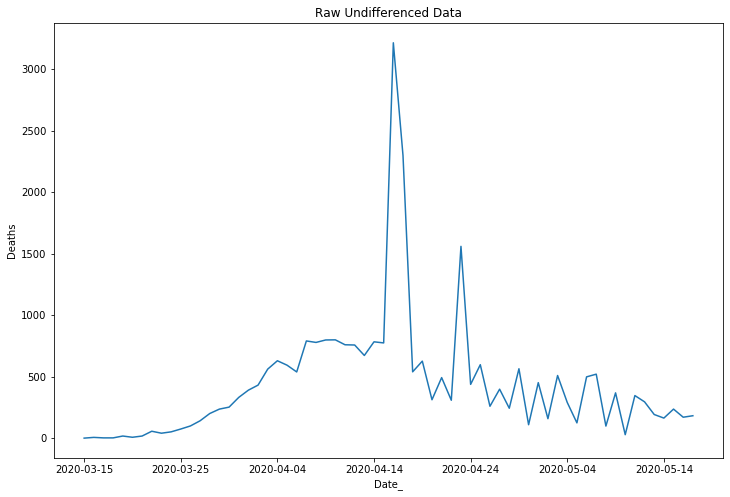

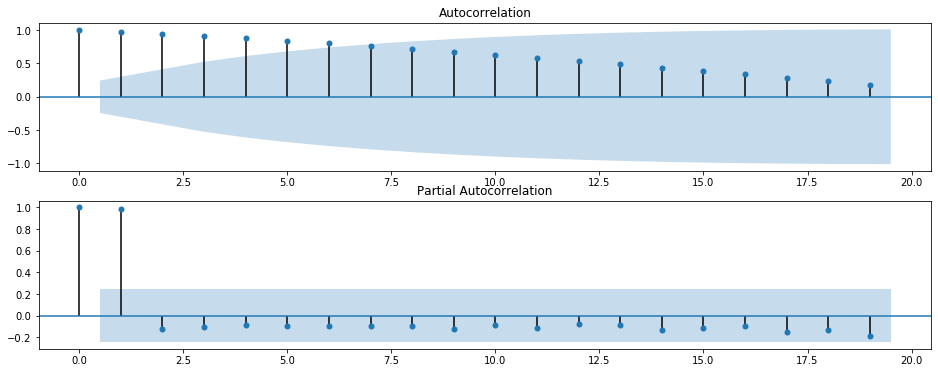

ARIMA(0, 0, 1) RMSE=11794.980
ARIMA(0, 1, 1) RMSE=706.686
ARIMA(1, 0, 0) RMSE=833.332
ARIMA(1, 1, 0) RMSE=621.077
Best ARIMA(1, 1, 0) RMSE=621.077
RMSE: 621.077
                 0
count    33.000000
mean     74.085114
std     626.203204
min   -1527.526943
25%    -171.174772
50%      21.276192
75%     273.497635
max    2445.801135


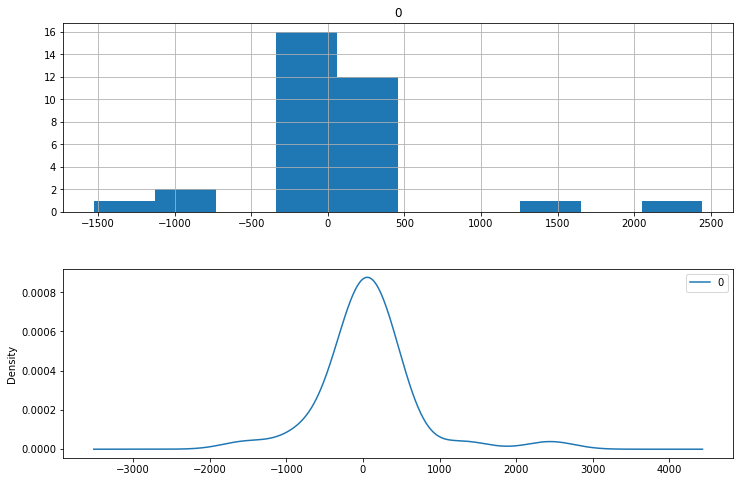


bias saved in arg_dict["bias"] for subsequent run is: 74.08511360751876 

RMSE: 616.642
                  0
count  3.300000e+01
mean   7.716925e-13
std    6.262032e+02
min   -1.601612e+03
25%   -2.452599e+02
50%   -5.280892e+01
75%    1.994125e+02
max    2.371716e+03


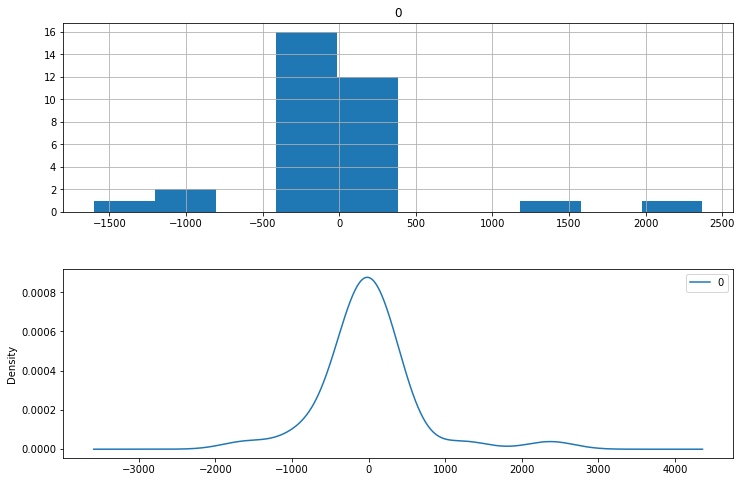


bias saved in arg_dict["bias"] for subsequent run is: 7.716924742315755e-13 



In [77]:
# Driver cell

# Need to load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Test for stationarity
df = st.driver(arg_dict)

# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# save df and arg_dict for subsequent independent processing
df.to_csv('df.csv')
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# summarize residual errors for an ARIMA model and return bias
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'bias': bias})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rerun summarize, as bias adjusted
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

The predicted cumulative Deaths for New York for tomorrow (input data plus 1 day) are 28,249


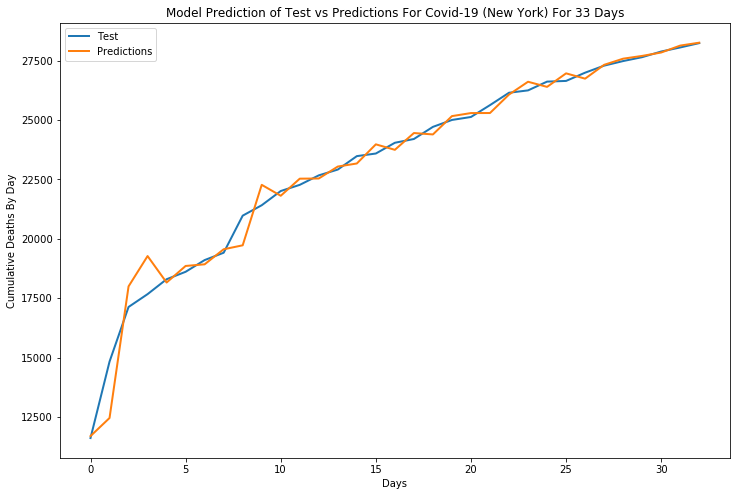

In [78]:
# Plot, save, and forecast
tpsf1.driver(arg_dict)

The New York prediction is for 645,419 cumulative Deaths to occur by 2020-12-31


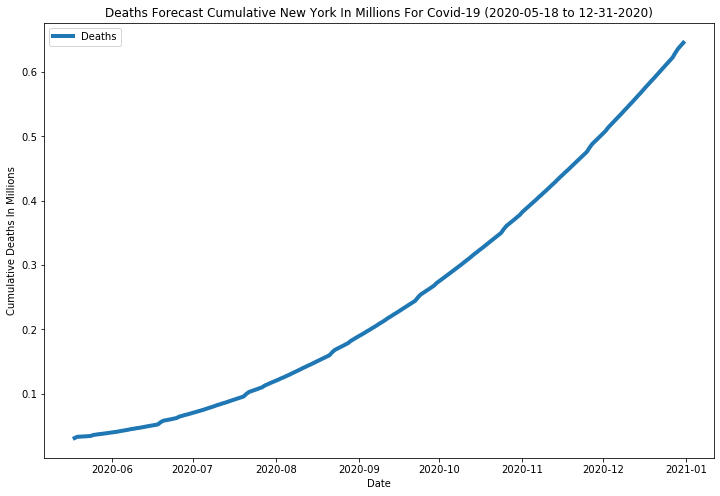

In [79]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

In [80]:
df['Daily_Deaths'] = df['Deaths'] - df['Deaths'].shift(1)
df.tail()

,Deaths,Daily_Deaths
Date_,,
2020-05-13,27477.0,193.0
2020-05-14,27641.0,164.0
2020-05-15,27878.0,237.0
2020-05-16,28049.0,171.0
2020-05-17,28232.0,183.0


In [81]:
forecast_df.head()

,Deaths,Deaths_e6
2020-05-18,30951.0,0.030951
2020-05-19,32845.0,0.032845
2020-05-20,33061.0,0.033061
2020-05-21,33441.0,0.033441
2020-05-22,33576.0,0.033576
